# DATA CHALLENGE

In this data challenge, we will try to build a predictive model to predict the win rate for a bid and analyze what the optimal bid amounts are able to maximize net revenue. In **Part A**, I will test several regression models, and show that the best model is given by random-forest-regression. With proper feature selection, the random-forest-regression also gives good performance. **Part B** is devoted to searching for the optimal bid to maximize net revenuse using the model.

The content is as follows:

+  **Part A**
 +  **A-1:** The Data
 +  **A-2:** Data Visualization
 +  **A-3:** Correlation Between Features and Target
     +   *A-3(a)*: Pearson correlation for numeric variables
     +   *A-3(b)*: Eta correlation for nominal variables
 +  **A-4:** Building Predictive Models
     +   *A-4(a)*: Consider all features
          +  (i) split the whole dataset to training set and test set:
          +  (ii) decision-tree-regression
          +  (iii) random-forest-regression
          +  (iv) gradient-boosting-regression
     +   *A-4(b)*: Feature selection
 +  **A-5:** Linear Regression Models
     +   *A-5(a)*: One-hot-encoding (OHE) representation
     +   *A-5(b)*: Linear regressions
          +   (i) ridge (L2) regression
          +   (ii) lasso (L1) regression
          +   (iii) Bayesian ridge regression
+  **Part B**
+  **Summary**

# **Part A**

In [115]:
import numpy as np
from time import time

## A-1: The Data

In the dataset, all data are indicated by numbers. However, only **PUBLISHER_BID**, **RESPONSES** and **WINS** are numeric continuous variables; others like **date**, **hour**, **traffic_source**, **device** and **coutnry** are actually categorical variables. Thus, we need to know the number of different categories in each of the categorical features. 

In [7]:
hd = open('DATA_SCIENCE_CHALLENGE.csv')
traffic_dict = {}
device_dict ={}
country_dict ={}
hour_dict ={}
date_dict ={}
x_bid = []
x_hour = []
x_date = []
x_response = []
y= []
row = 0
for line in hd:
    if row > 0:
        #print (line)
        line = line.split(',')
        date = line[1]
        hour = line[2]
        traffic = line[3]
        device = line[4]
        country = line[5]
        bid = float(line[6])
        win_rate = float(line[8])/int(line[7])
        
        ## remove the outliers, win_rate >1 and win_rate <0 data
        if win_rate >= 0 and win_rate <=1:
        
            x_bid.append(float(line[6]))
            y.append(win_rate)
            x_hour.append(int(hour))
            x_response.append(int(line[7]))
            x_date.append(int(date))
      
            if traffic not in traffic_dict:
                traffic_dict[traffic] = [win_rate]
            else:
                traffic_dict[traffic].append(win_rate)
        
            if device not in device_dict:
                device_dict[device] = [win_rate]
            else:
                device_dict[device].append(win_rate)    
        
            if country not in country_dict:
                country_dict[country] = [win_rate]
            else:
                country_dict[country].append(win_rate)
       
            #  ----------
        
            if date not in date_dict:
                date_dict[date] = [win_rate]
            else:
                date_dict[date].append(win_rate)
        
            if hour not in hour_dict:
                hour_dict[hour] = [win_rate]
            else:
                hour_dict[hour].append(win_rate)
    row += 1     

In [3]:
print (len(date_dict), len(hour_dict), len(traffic_dict), len(device_dict), len(country_dict))

8 24 319 12 27


By the above operations, we can identify the number of different categories for each categorical feature: there are **8 dates**, **24 hours**, **319 traffic_sources**, **12 device types**, and **27 countries** in the dataset. Note that these are nominal, rather than ordinal variables. **win_rate** was computed as **RESPONSES**/**WINS** for each observation .

## **A-2: Data Visualization**

Before we start to work on building models, it would be helpful if we can visualize what the relation between the features (**PUBLISHER_BID**, **hour**, and **RESPONSES**) and **win_rate** is. Is there linearity? or polynomial relation?

In [84]:
import matplotlib.pyplot as plt
import pylab
from pylab import *
%matplotlib inline
import seaborn as sns
def scatterplot(ax, title, x_label, y_label, x, y, upperlimit):
    ax.scatter(x, y, s=70, marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7)
    ax.set_xlabel(x_label, size=20)
    ax.set_ylabel(y_label, size=20)
    ax.set_title(title, size=20)
    plt.xlim(0,upperlimit)
    plt.ylim(0,1.1)

/Users/hhhung/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


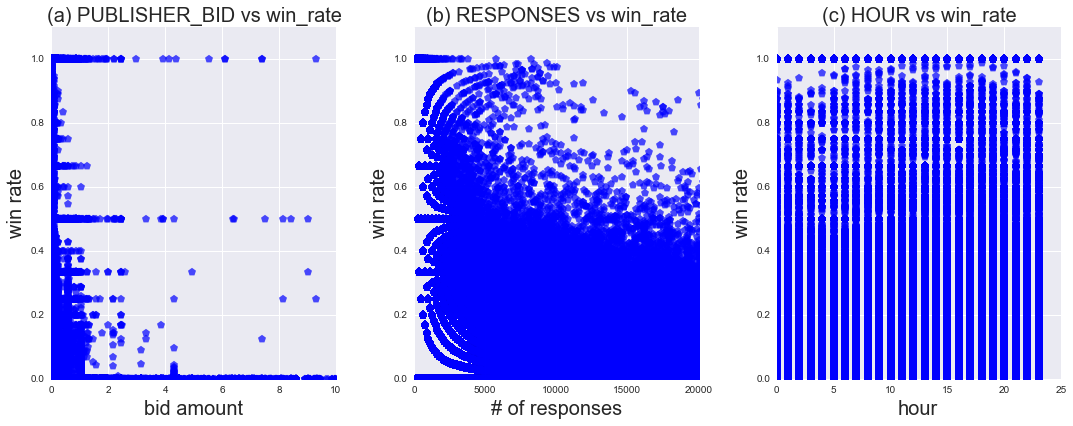

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15,6))
ax = plt.subplot(131)
scatterplot(ax, '(a) PUBLISHER_BID vs win_rate', 'bid amount', 'win rate', x_bid, y, 10)

ax = plt.subplot(132)
scatterplot(ax, '(b) RESPONSES vs win_rate', '# of responses', 'win rate', x_response, y, 20000)

ax = plt.subplot(133)
scatterplot(ax, '(c) HOUR vs win_rate', 'hour', 'win rate', x_hour, y, 25)

fig.tight_layout()
plt.show()

From these graphs, we are unable to explicitly determine if there is linearity or polynomial relation between **PUBLISHER_BID**, **RESPONSES**, **HOUR** and **win_rate**. However, we can roughly see there are negative correlations (although weak) between **PUBLISHER_BID - win_rate**, and **RESPONSES - win_rate** from (a) and (b), respectively. Later we will show more evidence to confirm this property.

## **A-3: Correlation Between Features and Target**

In the following we compute the correlation coefficients with respective to target **win_rate**. For numeric features, **PUBLISHER_BID** and **RESPONSES**, we can compute the Pearson correlation coefficients, which will be Cor(**bid**, **win_rate**) and Cor(**responses**, **win_rate**). For the categorical features, **date**, **hour**, **traffic sources**, **device**, **country**, we resort to eta correlation.

In [10]:
avg_y = np.mean(y)
sigma_y = (np.std(y)**2)*len(y)

### **A-3 (a): Pearson correlation for numeric variables**

In [11]:
print ('Cor(bid, win_rate)=', np.corrcoef(x_bid, y)[0, 1])
print ('Cor(response, win_rate)=', np.corrcoef(x_response, y)[0, 1])

Cor(bid, win_rate)= -0.0306759601389
Cor(response, win_rate)= -0.0256345358549


Here we can see the correlation coefficients between **PUBLISHER_BID - win_rate** and **RESPONSES - win_rate** are small negative numbers, meaning negative correlations. This indication is consistent with the previous visualization.

### **A-3 (b): Eta correlation for nominal variables**

For nominal variables, we use [eta correlation](https://en.wikipedia.org/wiki/Correlation_ratio):
### $$ \eta^2 = \frac{\sum_c n_c (\bar{y}_c-\bar{y})^2}{\sum_{c,i}(y_{ci}-\bar{y})^2}, $$
where $\bar{y}_c$ is the mean in the category c and $\bar{y}$ is the mean over all population, i.e.
### $$ \bar{y}_c = \frac{\sum_{i\in c} y_{ci}}{n_c} , \ \bar{y} = \frac{\sum_{ci}y_{ci}}{\sum_c n_c}$$ 
and $n_c$ is the number of samples belonging to category c. Here $y$ is **win_rate**.

In [12]:
def eta_correlation_ratio(a_dict, avg_y, num_y):
    eta_sq = 0
    for key in a_dict:
        avg_category = np.mean(a_dict[key])
        n_category = len(a_dict[key])
        eta_sq += n_category*((avg_category-avg_y)**2)
        #print (key, n_category, avg_category, n_category*(avg_category-avg_y)**2)
    return np.sqrt(eta_sq/num_y)

In [14]:
print ('Eta(date,rate)=   ', eta_correlation_ratio(date_dict, avg_y, sigma_y))
print ('Eta(hour,rate)=   ', eta_correlation_ratio(hour_dict, avg_y, sigma_y))
print ('Eta(traffic,rate)=', eta_correlation_ratio(traffic_dict, avg_y, sigma_y))
print ('Eta(device,rate) =', eta_correlation_ratio(device_dict, avg_y, sigma_y))
print ('Eta(country,rate)=', eta_correlation_ratio(country_dict, avg_y, sigma_y))

Eta(date,rate)=    0.0174280193839
Eta(hour,rate)=    0.0701491127019
Eta(traffic,rate)= 0.381123092852
Eta(device,rate) = 0.131468650475
Eta(country,rate)= 0.305881222874


From the eta correlations, we learned that **traffic_source**, and **country** are the top 2 important features. **device** is third. **date** and **hour** may be relatively less important compared to the top three (although Pearson and eta correlation are not comparable).

## **A-4: Building Predictive Models**

In this subsection, we will build models using decision-tree-regression, random-forest-regression and gradient-boosting-regression. The reason we first try these models is that we don't have worry about the nominal features. In A-5 subsection, I will convert the nominal variables to one-hot-encoding representation and test other linear regression models.

We first consider all features to train the models. Then I will show some features are removable and after doing that we still have similarly good regression models. In each benchmark test, we use **RMSE (root-mean-square-error)** and **R square** as metrics. Lower RMSE and higher R square denote a better regression model.

In [24]:
import pandas as pd
data = pd.read_csv('DATA_SCIENCE_CHALLENGE.csv')
data.head()

,INDEX,RPT_DATE,RPT_HOUR,TRAFFIC_SOURCE,DEVICE_SUBTYPE,COUNTRY_ID,PUBLISHER_BID,RESPONSES,WINS
0,1,8,23,66686962,10025,9,0.00743,252,0
1,2,8,23,66686962,22,27,0.00743,252,0
2,3,8,23,66686962,22,9,0.00743,126,0
3,4,8,23,66686962,22,9,0.01486,252,0
4,5,8,23,66686962,22,77,0.01486,126,0


In [25]:
data.shape

(760841, 9)

Here I generate another column **win_rate** in the dataframe. Also, I found there are few outliers, where **win_rate >1** or even **win_rate <0**, which does not make any sense. I will remove them from the data.

In [26]:
data['win_rate'] = pd.Series(data['WINS']/data['RESPONSES'], index=data.index)
del data['WINS']
data = data[data.win_rate <= 1]
data = data[data.win_rate >=0]

In [27]:
data.head()

,INDEX,RPT_DATE,RPT_HOUR,TRAFFIC_SOURCE,DEVICE_SUBTYPE,COUNTRY_ID,PUBLISHER_BID,RESPONSES,win_rate
0,1,8,23,66686962,10025,9,0.00743,252,0
1,2,8,23,66686962,22,27,0.00743,252,0
2,3,8,23,66686962,22,9,0.00743,126,0
3,4,8,23,66686962,22,9,0.01486,252,0
4,5,8,23,66686962,22,77,0.01486,126,0


In [28]:
data.shape

(760837, 9)

In [54]:
'''This function is used to compute RMSE and R square'''
def R_squared(predict, true):
    if len(predict) != len(true): return False
    meanTrue = np.mean(true)
    RSS =0
    TSS =0
    for i in range(len(predict)):
        RSS += (predict[i] - true[i])**2
        TSS += (true[i] - meanTrue)**2
    return np.sqrt(RSS/len(predict)), 1.0-RSS/TSS

### **A-4 (a): Consider all features**

Here we will use all features to train models. Note that KNN and usual linear regressions are NOT accessible here since the **DATE**, **HOUR**... **COUNTRY** are nominal features. I will try decision-tree-regression, random-forest-regression and gradient-boosting-regression.

In [159]:
X = data.iloc[:,1:8]
y = data.iloc[:,8]
X.head()

,RPT_DATE,RPT_HOUR,TRAFFIC_SOURCE,DEVICE_SUBTYPE,COUNTRY_ID,PUBLISHER_BID,RESPONSES
0,8,23,66686962,10025,9,0.00743,252
1,8,23,66686962,22,27,0.00743,252
2,8,23,66686962,22,9,0.00743,126
3,8,23,66686962,22,9,0.01486,252
4,8,23,66686962,22,77,0.01486,126


In [129]:
X.shape, y.shape

((760837, 7), (760837,))

In [32]:
y.head(10)

0    0.00
1    0.00
2    0.00
3    0.00
4    0.00
5    0.00
6    0.00
7    0.00
8    0.00
9    0.25
Name: win_rate, dtype: float64

### (i) split the whole dataset to training set and test set:

In [130]:
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import metrics, cross_validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_test = y_test.tolist()

### **(ii) decision-tree-regression**

In [26]:
from sklearn.tree import DecisionTreeRegressor
decTreeReg = DecisionTreeRegressor(random_state=100)
decTreeReg.fit(X_train, y_train)
predictedY = decTreeReg.predict(X_test)
print (R_squared(predictedY, y_test))

(0.27217527397379737, -0.25180950418906511)


The first number is the **RMSE=0.272**, and second is the **R square = 0.25**. The small value of R square hints that the model doesn't capture the variance well. Next we try grid search:

In [162]:
from sklearn import grid_search
from sklearn.tree import DecisionTreeRegressor
decTreeReg = DecisionTreeRegressor(random_state=10)
parameters = {'max_depth':[5,15,20,25,30],'min_samples_leaf':[5,10,20,30]}
model_cv_grid = grid_search.GridSearchCV(decTreeReg,parameters,cv=5, verbose=2,n_jobs=-1)
model_cv_grid.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] ........................ max_depth=5, min_samples_leaf=5 -   2.8s[CV] ........................ max_depth=5, min_samples_leaf=5 -   3.0s[CV] ........................ max_depth=5, min_samples_leaf=5 -   2.9s[CV] ........................ max_depth=5, min_samples_leaf=5 -   2.9s



[CV] max_depth=5, min_samples_leaf=5 .................................[CV] max_depth=5, min_samples_leaf=10 ................................
[CV] max_depth=5, min_samples_leaf=10 ................................[CV] max_depth=5, min_samples_leaf=10 ................................

[CV] ....................... max_depth=5, min_samples_leaf=10 -   2.7s
[CV] ....................... max_depth=5, min_samples_leaf=10 -   2.6s[CV] ...

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=10,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 15, 20, 25, 30], 'min_samples_leaf': [5, 10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)


[CV] ....................... max_depth=30, min_samples_leaf=5 -   6.0s

[CV] max_depth=25, min_samples_leaf=20 ...............................
[CV] max_depth=25, min_samples_leaf=30 ...............................[CV] max_depth=25, min_samples_leaf=30 ...............................
[CV] max_depth=30, min_samples_leaf=5 ................................

[CV] ...................... max_depth=25, min_samples_leaf=20 -   5.6s
[CV] ...................... max_depth=25, min_samples_leaf=30 -   5.3s[CV] ...................... max_depth=25, min_samples_leaf=30 -   5.3s
[CV] ....................... max_depth=30, min_samples_leaf=5 -   6.1s

[CV] max_depth=25, min_samples_leaf=30 ...............................

[CV] max_depth=30, min_samples_leaf=5 ................................[CV] max_depth=30, min_samples_leaf=5 ................................[CV] ...................... max_depth=25, min_samples_leaf=30 -   5.3s[CV] max_depth=30, min_samples_leaf=20 ...............................



[CV

In [163]:
model_cv_grid.grid_scores_

[mean: 0.12206, std: 0.00157, params: {'max_depth': 5, 'min_samples_leaf': 5},
 mean: 0.12206, std: 0.00157, params: {'max_depth': 5, 'min_samples_leaf': 10},
 mean: 0.12206, std: 0.00157, params: {'max_depth': 5, 'min_samples_leaf': 20},
 mean: 0.12202, std: 0.00158, params: {'max_depth': 5, 'min_samples_leaf': 30},
 mean: 0.26531, std: 0.00470, params: {'max_depth': 15, 'min_samples_leaf': 5},
 mean: 0.27313, std: 0.00336, params: {'max_depth': 15, 'min_samples_leaf': 10},
 mean: 0.27876, std: 0.00304, params: {'max_depth': 15, 'min_samples_leaf': 20},
 mean: 0.27861, std: 0.00327, params: {'max_depth': 15, 'min_samples_leaf': 30},
 mean: 0.24385, std: 0.00595, params: {'max_depth': 20, 'min_samples_leaf': 5},
 mean: 0.28545, std: 0.00304, params: {'max_depth': 20, 'min_samples_leaf': 10},
 mean: 0.30633, std: 0.00247, params: {'max_depth': 20, 'min_samples_leaf': 20},
 mean: 0.30868, std: 0.00143, params: {'max_depth': 20, 'min_samples_leaf': 30},
 mean: 0.20452, std: 0.00641, param

In [164]:
best_tree_model = model_cv_grid.best_estimator_
best_tree_model

DecisionTreeRegressor(criterion='mse', max_depth=30, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=30, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=10,
           splitter='best')

In [165]:
best_tree_model.fit(X_train, y_train)
predictedY = best_tree_model.predict(X_test)
print (R_squared(predictedY, y_test))

(0.20116099396649775, 0.32133626865514531)


After grid search, we have the optimal decision-tree model which provides lower RMSE and higher R square than a single shoot training.

### **(iii) random-forest-regression**

In [34]:
from sklearn.ensemble import RandomForestRegressor
rfReg = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=100, verbose=0, warm_start=False)
rfReg.fit(X_train, y_train)
predictedY = rfReg.predict(X_test)
print (R_squared(predictedY, y_test))

(0.2084949762581379, 0.28007221723664366)


We can see the advantage of using the random-forest-regression. Even without doing grid search, the RMSE and R square are as good as ones from the optimal decision-tree-regression model. Next let's further go grid search on the random-forest-regression:

In [166]:
from sklearn import grid_search
from sklearn.ensemble import RandomForestRegressor
rfReg = RandomForestRegressor()
parameters = {'n_estimators': [4,8],'max_depth':[5,15,20,25,30],'min_samples_leaf':[5,10,20,30]}
model_cv_grid = grid_search.GridSearchCV(rfReg,parameters,cv =5, verbose=2,n_jobs=-1)
model_cv_grid.fit(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 16.7min finished


[CV] n_estimators=4, max_depth=5, min_samples_leaf=5 .................
[CV] n_estimators=4, max_depth=5, min_samples_leaf=5 .................
[CV] n_estimators=4, max_depth=5, min_samples_leaf=5 .................
[CV] n_estimators=4, max_depth=5, min_samples_leaf=5 .................
[CV] ........ n_estimators=4, max_depth=5, min_samples_leaf=5 -   7.6s[CV] ........ n_estimators=4, max_depth=5, min_samples_leaf=5 -   7.8s[CV] ........ n_estimators=4, max_depth=5, min_samples_leaf=5 -   8.0s[CV] ........ n_estimators=4, max_depth=5, min_samples_leaf=5 -   7.6s



[CV] n_estimators=4, max_depth=5, min_samples_leaf=5 .................[CV] n_estimators=8, max_depth=5, min_samples_leaf=5 .................
[CV] n_estimators=8, max_depth=5, min_samples_leaf=5 .................
[CV] n_estimators=8, max_depth=5, min_samples_leaf=5 .................
[CV] ........ n_estimators=8, max_depth=5, min_samples_leaf=5 -  16.6s[CV] ........ n_estimators=8, max_depth=5, min_samples_leaf=5 -  16.6s
[CV] ...

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [4, 8], 'max_depth': [5, 15, 20, 25, 30], 'min_samples_leaf': [5, 10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)




[CV] ...... n_estimators=4, max_depth=15, min_samples_leaf=30 -  12.8s[CV] n_estimators=8, max_depth=15, min_samples_leaf=30 ...............[CV] n_estimators=4, max_depth=20, min_samples_leaf=5 ................[CV] ...... n_estimators=4, max_depth=15, min_samples_leaf=30 -  13.9s



[CV] n_estimators=8, max_depth=15, min_samples_leaf=30 ...............
[CV] ...... n_estimators=8, max_depth=15, min_samples_leaf=30 -  30.6s[CV] ....... n_estimators=4, max_depth=20, min_samples_leaf=5 -  15.5s[CV] n_estimators=8, max_depth=15, min_samples_leaf=30 ...............
[CV] ...... n_estimators=8, max_depth=15, min_samples_leaf=30 -  30.5s

[CV] ...... n_estimators=8, max_depth=15, min_samples_leaf=30 -  30.6s
[CV] n_estimators=4, max_depth=20, min_samples_leaf=5 ................[CV] n_estimators=8, max_depth=20, min_samples_leaf=5 ................

[CV] n_estimators=4, max_depth=20, min_samples_leaf=5 ................

[CV] ....... n_estimators=8, max_depth=20, min_samples_leaf=5 -  33.1s[CV]

In [167]:
model_cv_grid.grid_scores_

[mean: 0.12764, std: 0.00125, params: {'n_estimators': 4, 'max_depth': 5, 'min_samples_leaf': 5},
 mean: 0.12858, std: 0.00085, params: {'n_estimators': 8, 'max_depth': 5, 'min_samples_leaf': 5},
 mean: 0.12784, std: 0.00159, params: {'n_estimators': 4, 'max_depth': 5, 'min_samples_leaf': 10},
 mean: 0.12838, std: 0.00104, params: {'n_estimators': 8, 'max_depth': 5, 'min_samples_leaf': 10},
 mean: 0.12692, std: 0.00183, params: {'n_estimators': 4, 'max_depth': 5, 'min_samples_leaf': 20},
 mean: 0.12850, std: 0.00045, params: {'n_estimators': 8, 'max_depth': 5, 'min_samples_leaf': 20},
 mean: 0.12790, std: 0.00081, params: {'n_estimators': 4, 'max_depth': 5, 'min_samples_leaf': 30},
 mean: 0.12797, std: 0.00066, params: {'n_estimators': 8, 'max_depth': 5, 'min_samples_leaf': 30},
 mean: 0.30034, std: 0.00285, params: {'n_estimators': 4, 'max_depth': 15, 'min_samples_leaf': 5},
 mean: 0.31354, std: 0.00315, params: {'n_estimators': 8, 'max_depth': 15, 'min_samples_leaf': 5},
 mean: 0.305

In [168]:
best_rf_model = model_cv_grid.best_estimator_
best_rf_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=8, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [169]:
best_rf_model.fit(X_train, y_train)
predictedY = best_rf_model.predict(X_test)
print (R_squared(predictedY, y_test))

(0.19675389748813008, 0.35074727231530989)


We can clearly see with the grid search, the RMSE and R sqaure are even slightly improved: RMSE =0.208 -> 0.198, and R sqaure = 0.28 -> 0.35, meaning we capture more variance from the model. Next we can list which features are important:

In [171]:
importance = best_rf_model.feature_importances_
attribute = X.columns
v = sorted(range(len(importance)), key=lambda k: importance[k], reverse=True)
sorted_importance = [importance[i] for i in v]
sorted_attribute = [attribute[i] for i in v]
df_importance = pd.DataFrame({'variable': sorted_attribute, 'importance' : sorted_importance})
df_importance.sort_index().head(7)

,importance,variable
0,0.392915,TRAFFIC_SOURCE
1,0.211008,COUNTRY_ID
2,0.092912,RPT_HOUR
3,0.086251,PUBLISHER_BID
4,0.080205,RESPONSES
5,0.068840,DEVICE_SUBTYPE
6,0.067869,RPT_DATE


The most important features are **traffic_source** and **country**, which is consistent with the observation using Eta correlation in the last section.

### **(iv) gradient-boosting-regression**

**(Note that this algorithm is time-consuming and computationally expansive.)**
Gradient Boosted Regression Trees is a generalization of boosting to arbitrary differentiable loss functions, supporting a number of different loss functions. Here we use the default 'ls'= least square for regression.

In [136]:
from sklearn import grid_search
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators=7)
parameters = {'learning_rate': [0.1, 0.2, 0.5, 1],'max_depth':[3,6,9,12]}
model_cv_grid = grid_search.GridSearchCV(GBR, parameters, cv=5, verbose=2, n_jobs=-1)
model_cv_grid.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 50.9min finished


[CV] max_depth=3, learning_rate=0.1 ..................................
[CV] max_depth=3, learning_rate=0.1 ..................................
[CV] max_depth=3, learning_rate=0.1 ..................................
[CV] max_depth=6, learning_rate=0.1 ..................................
[CV] ......................... max_depth=3, learning_rate=0.1 -  10.2s[CV] ......................... max_depth=3, learning_rate=0.1 -  10.1s[CV] ......................... max_depth=3, learning_rate=0.1 -  10.2s[CV] ......................... max_depth=6, learning_rate=0.1 -  33.0s



[CV] max_depth=6, learning_rate=0.1 ..................................
[CV] max_depth=6, learning_rate=0.1 ..................................
[CV] max_depth=9, learning_rate=0.1 ..................................
[CV] max_depth=9, learning_rate=0.1 ..................................
[CV] ......................... max_depth=6, learning_rate=0.1 -  35.0s[CV] ......................... max_depth=6, learning_rate=0.1 -  34.9s[CV] ...

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=7, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 6, 9, 12], 'learning_rate': [0.1, 0.2, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [137]:
model_cv_grid.grid_scores_

[mean: 0.06893, std: 0.00056, params: {'max_depth': 3, 'learning_rate': 0.1},
 mean: 0.11537, std: 0.00029, params: {'max_depth': 6, 'learning_rate': 0.1},
 mean: 0.15860, std: 0.00083, params: {'max_depth': 9, 'learning_rate': 0.1},
 mean: 0.20667, std: 0.00047, params: {'max_depth': 12, 'learning_rate': 0.1},
 mean: 0.09966, std: 0.00121, params: {'max_depth': 3, 'learning_rate': 0.2},
 mean: 0.15780, std: 0.00094, params: {'max_depth': 6, 'learning_rate': 0.2},
 mean: 0.21902, std: 0.00115, params: {'max_depth': 9, 'learning_rate': 0.2},
 mean: 0.27478, std: 0.00056, params: {'max_depth': 12, 'learning_rate': 0.2},
 mean: 0.14081, std: 0.00111, params: {'max_depth': 3, 'learning_rate': 0.5},
 mean: 0.21807, std: 0.00640, params: {'max_depth': 6, 'learning_rate': 0.5},
 mean: 0.27859, std: 0.00142, params: {'max_depth': 9, 'learning_rate': 0.5},
 mean: 0.30745, std: 0.00295, params: {'max_depth': 12, 'learning_rate': 0.5},
 mean: 0.14990, std: 0.00471, params: {'max_depth': 3, 'learn

In [138]:
best_GBR_model = model_cv_grid.best_estimator_
best_GBR_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=12, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=7, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [139]:
best_GBR_model.fit(X_train, y_train)
predictedY = best_GBR_model.predict(X_test)
print (R_squared(predictedY, y_test))

(0.20153252244023914, 0.31882707699399238)


We can see the gradient-boosting-regression gives results close to the decision-tree-regression, but still slightly worse than the random-forest-regression. Thus in the non-linear models, the random-forest-regression has the best performance.

### **A-4 (b): Feature selection**

In this subsection, I will select important features to train models. From the eta correlations, **traffic_source**, **country** and **device** are more important than **date** and **hour**. For numeric features, our benchmark results show **RESPONSES** is not much relevant (I did try consider **RESPONSES** to train models and have slightly worse performance than that without the feature). So in the follwoing we only consider 4 features: **traffic_source**, **country**, **device** and **PUBLISHER_BID** to build models.

In [172]:
X = data.iloc[:,[3,4,5,6]]
y = data.iloc[:,8]
X.head()

,TRAFFIC_SOURCE,DEVICE_SUBTYPE,COUNTRY_ID,PUBLISHER_BID
0,66686962,10025,9,0.00743
1,66686962,22,27,0.00743
2,66686962,22,9,0.00743
3,66686962,22,9,0.01486
4,66686962,22,77,0.01486


In [173]:
from sklearn.cross_validation import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape
y_test = y_test.tolist()

In [174]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
rfReg = RandomForestRegressor()
parameters = {'n_estimators': [2,4],'max_depth':[5,15,20,25,30],'min_samples_leaf':[5,10,20,30]}
model_cv_grid = grid_search.GridSearchCV(rfReg,parameters,cv=5,verbose=2,n_jobs=-1)
model_cv_grid.fit(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.3min finished


[CV] n_estimators=2, max_depth=5, min_samples_leaf=5 .................
[CV] n_estimators=2, max_depth=5, min_samples_leaf=5 .................
[CV] n_estimators=2, max_depth=5, min_samples_leaf=5 .................
[CV] n_estimators=2, max_depth=5, min_samples_leaf=5 .................
[CV] ........ n_estimators=2, max_depth=5, min_samples_leaf=5 -   3.6s[CV] ........ n_estimators=2, max_depth=5, min_samples_leaf=5 -   3.8s[CV] ........ n_estimators=2, max_depth=5, min_samples_leaf=5 -   3.8s[CV] ........ n_estimators=2, max_depth=5, min_samples_leaf=5 -   3.9s



[CV] n_estimators=2, max_depth=5, min_samples_leaf=5 .................[CV] n_estimators=4, max_depth=5, min_samples_leaf=5 .................
[CV] n_estimators=4, max_depth=5, min_samples_leaf=5 .................[CV] n_estimators=4, max_depth=5, min_samples_leaf=5 .................

[CV] ........ n_estimators=4, max_depth=5, min_samples_leaf=5 -   4.6s
[CV] ........ n_estimators=4, max_depth=5, min_samples_leaf=5 -   4.5s[CV] ...

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [2, 4], 'max_depth': [5, 15, 20, 25, 30], 'min_samples_leaf': [5, 10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

[CV] ...... n_estimators=4, max_depth=15, min_samples_leaf=30 -   7.6s[CV] ....... n_estimators=2, max_depth=20, min_samples_leaf=5 -   4.5s



[CV] n_estimators=2, max_depth=20, min_samples_leaf=5 ................
[CV] n_estimators=2, max_depth=20, min_samples_leaf=5 ................
[CV] n_estimators=4, max_depth=15, min_samples_leaf=30 ...............
[CV] n_estimators=4, max_depth=20, min_samples_leaf=5 ................
[CV] ....... n_estimators=2, max_depth=20, min_samples_leaf=5 -   4.6s[CV] ....... n_estimators=2, max_depth=20, min_samples_leaf=5 -   4.6s[CV] ...... n_estimators=4, max_depth=15, min_samples_leaf=30 -   7.1s[CV] ....... n_estimators=4, max_depth=20, min_samples_leaf=5 -   8.0s



[CV] n_estimators=2, max_depth=20, min_samples_leaf=5 ................
[CV] n_estimators=2, max_depth=20, min_samples_leaf=5 ................
[CV] n_estimators=4, max_depth=20, min_samples_leaf=5 ................
[CV] n_estimators=2, max_depth=20, min_samples_leaf=10 ...............
[CV]

In [175]:
model_cv_grid.grid_scores_

[mean: 0.12578, std: 0.00112, params: {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 5},
 mean: 0.12665, std: 0.00152, params: {'n_estimators': 4, 'max_depth': 5, 'min_samples_leaf': 5},
 mean: 0.12525, std: 0.00086, params: {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 10},
 mean: 0.12630, std: 0.00149, params: {'n_estimators': 4, 'max_depth': 5, 'min_samples_leaf': 10},
 mean: 0.12446, std: 0.00149, params: {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 20},
 mean: 0.12752, std: 0.00109, params: {'n_estimators': 4, 'max_depth': 5, 'min_samples_leaf': 20},
 mean: 0.12598, std: 0.00094, params: {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 30},
 mean: 0.12578, std: 0.00109, params: {'n_estimators': 4, 'max_depth': 5, 'min_samples_leaf': 30},
 mean: 0.30693, std: 0.00363, params: {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 5},
 mean: 0.31605, std: 0.00393, params: {'n_estimators': 4, 'max_depth': 15, 'min_samples_leaf': 5},
 mean: 0.311

In [176]:
best_rf_model = model_cv_grid.best_estimator_
best_rf_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=4, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [177]:
best_rf_model.fit(X_train, y_train)
predictedY = best_rf_model.predict(X_test)
print (R_squared(predictedY, y_test))

(0.19727945853054363, 0.35645557675242623)


Now we can see that in comparison with the model with all features, the model with important features only shows similarly good performance as the models considering all features. This indicates the four features, **traffic source**, **device**, **country** and **PUBLISHER_BID** have captured the variance in the dataset.

One thing is worthy to notice. Considering feature selection, we are still able to obtain good RMSE and high R square using the random-forest-regression model, even **without** doing grid search. This can save our time if the dataset is much bigger. As an example, the following shows a **single shoot test** for the random-forest-regression model:

In [111]:
from sklearn.ensemble import RandomForestRegressor
rfReg = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=100, verbose=0, warm_start=False)
rfReg.fit(X_train, y_train)
predictedY = rfReg.predict(X_test)
print (R_squared(predictedY, y_test))

(0.19736961157131552, 0.35377915775728075)


## **A-5: Linear Regression Models**

Previously we only consider decision-tree, random-forest models and gradient-boosting-regression. With categorical features, these models are useful. In this subsection, we will try other regression models: linear regression with L1 and L2 regularizations, Bayesian regression. However, the nominal features are needed to convert to one-hot-encdoing representation for the regression algorithms.

### **A-5 (a): One-hot-encoding (OHE) representation**

In [53]:
import pandas as pd
OHE_data = pd.read_csv('DATA_SCIENCE_CHALLENGE.csv')
OHE_data['win_rate'] = pd.Series(OHE_data['WINS']/OHE_data['RESPONSES'], index=OHE_data.index)
del OHE_data['WINS']
OHE_data = OHE_data[OHE_data.win_rate <= 1]
OHE_data = OHE_data[OHE_data.win_rate >=0]
OHE_data.head(3)

,INDEX,RPT_DATE,RPT_HOUR,TRAFFIC_SOURCE,DEVICE_SUBTYPE,COUNTRY_ID,PUBLISHER_BID,RESPONSES,win_rate
0,1,8,23,66686962,10025,9,0.00743,252,0
1,2,8,23,66686962,22,27,0.00743,252,0
2,3,8,23,66686962,22,9,0.00743,126,0


We can see if the categorical features are indicated by numbers, using "get_dummies" does not work:

In [51]:
OHE_data = pd.get_dummies(OHE_data)
OHE_data.head(3)

,INDEX,RPT_DATE,RPT_HOUR,TRAFFIC_SOURCE,DEVICE_SUBTYPE,COUNTRY_ID,PUBLISHER_BID,RESPONSES,win_rate
0,1,8,23,66686962,10025,9,0.00743,252,0
1,2,8,23,66686962,22,27,0.00743,252,0
2,3,8,23,66686962,22,9,0.00743,126,0


The pandas library won't convert the categorical features labeled by numbers to OHE representation (dummy variable). For this purpose, I first transform all numbers to letters. Once the categorical features are indicated by characters, they are accessible to convert to OHE representation.

In [55]:
transform_nums = {'1':'a', '2':'b', '3':'c', '4':'d', '5':'e', '6':'f', '7':'g', '8':'h', '9':'i', '0':'j'}
def feature_convert(a_dict):
    mapping = {}
    for key in list(a_dict.keys()):
        s = ''
        for i in range(len(key)):
            s += transform_nums[key[i]]
        mapping[int(key)] = s
    return mapping

In [56]:
date_mapping = feature_convert(date_dict)
hour_mapping = feature_convert(hour_dict)
traffic_mapping = feature_convert(traffic_dict)
device_mapping = feature_convert(device_dict)
country_mapping = feature_convert(country_dict)

In [57]:
OHE_data['RPT_DATE'] = OHE_data['RPT_DATE'].map(date_mapping)
OHE_data['RPT_HOUR'] = OHE_data['RPT_HOUR'].map(hour_mapping)
OHE_data['TRAFFIC_SOURCE'] = OHE_data['TRAFFIC_SOURCE'].map(traffic_mapping)
OHE_data['DEVICE_SUBTYPE'] = OHE_data['DEVICE_SUBTYPE'].map(device_mapping)
OHE_data['COUNTRY_ID'] = OHE_data['COUNTRY_ID'].map(country_mapping)

In [58]:
OHE_data.head(3)

,INDEX,RPT_DATE,RPT_HOUR,TRAFFIC_SOURCE,DEVICE_SUBTYPE,COUNTRY_ID,PUBLISHER_BID,RESPONSES,win_rate
0,1,h,bc,fffhfifb,ajjbe,i,0.00743,252,0
1,2,h,bc,fffhfifb,bb,bg,0.00743,252,0
2,3,h,bc,fffhfifb,bb,i,0.00743,126,0


In [59]:
OHE_data = pd.get_dummies(OHE_data)

In [60]:
OHE_data.head(3)

,INDEX,PUBLISHER_BID,RESPONSES,win_rate,RPT_DATE_a,RPT_DATE_b,RPT_DATE_c,RPT_DATE_d,RPT_DATE_e,RPT_DATE_f,...,COUNTRY_ID_cb,COUNTRY_ID_ci,COUNTRY_ID_dd,COUNTRY_ID_f,COUNTRY_ID_g,COUNTRY_ID_gd,COUNTRY_ID_gg,COUNTRY_ID_h,COUNTRY_ID_i,COUNTRY_ID_ij
0,1,0.00743,252,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0.00743,252,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0.00743,126,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


We can see now the categorical features are in OHE representation. The feature dimension however becomes 394:

In [61]:
OHE_data.shape

(760837, 394)

In [117]:
a = list(range(4,OHE_data.shape[1])) ## X_features start from RPT_DATE...
a.insert(0,2)
a.insert(0,1)
'''consider all features as features except for "win_rate".'''
X = OHE_data.iloc[:,a]
y = OHE_data.iloc[:,3]
X.head(3)

,PUBLISHER_BID,RESPONSES,RPT_DATE_a,RPT_DATE_b,RPT_DATE_c,RPT_DATE_d,RPT_DATE_e,RPT_DATE_f,RPT_DATE_g,RPT_DATE_h,...,COUNTRY_ID_cb,COUNTRY_ID_ci,COUNTRY_ID_dd,COUNTRY_ID_f,COUNTRY_ID_g,COUNTRY_ID_gd,COUNTRY_ID_gg,COUNTRY_ID_h,COUNTRY_ID_i,COUNTRY_ID_ij
0,0.00743,252,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.00743,252,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.00743,126,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


Note that the features **PUBLISHER_BID** and **RESPONSES** are in different scales, we need to standardize the features:

In [63]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X = stdsc.fit_transform(X)

In [64]:
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import metrics, cross_validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
y_test = y_test.tolist()

(608669, 392) (608669,)
(152168, 392) (152168,)


Now we have categorical features in OHE representation and standardized numeric features, ready to perform linear regression! In the following, we test ridge regression (L2), lasso (L1) and Bayesian regression. For the first two we implement 10-fold cross-validation. Note that here we don't consider the kNN regression. The large number of features (392) makes the regression computationally expansive and the results will be subject to dimensionality curse. 

### **A-5 (b): Linear regression**

### **(i) ridge (L2) regression**

In [65]:
from sklearn import linear_model
best_ridge_model = None
max_rscore = -1
best_lambda = -1
for lambda_i in [1e-2, 0.1, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0]:
    ridge = linear_model.Ridge(alpha=lambda_i)
    cv_score = cross_val_score(ridge, X_train, y_train, cv=10)
    print (lambda_i, np.mean(cv_score))
    if np.mean(cv_score) > max_rscore:
        max_rscore = np.mean(cv_score)
        best_ridge_model = ridge
        best_lambda = lambda_i
        
best_ridge_model.fit(X_train, y_train)
predictedY = best_ridge_model.predict(X_test)
print (best_lambda, R_squared(predictedY, y_test))

0.01 0.229569811873
0.1 0.229569812186
1.0 0.229569814636
2.0 0.229569817348
3.0 0.229569820059
5.0 0.229569825473
7.0 0.229569830881
10.0 0.229569838978
10.0 (0.21463100017447201, 0.23038577079649958)


The best ridge model gives RMSE = 0.215 and R square =0.23, higher RMSE and lower R square than the random-forest model (RMSE=0.198, R^2 =0.35). Therefore its performance is worse than the random-forest-regression. 

As usual, in the linear regression model, we can also observe the weight coefficients to see which features are important, as shown below. However, the poor model performance is unable to give us any information here.

In [66]:
best_ridge_model.coef_

array([  1.06512359e-03,  -2.02773685e-03,  -1.41031475e-03,
        -1.04329176e-03,  -9.47676916e-04,   2.19276888e-03,
         2.64665278e-03,  -1.22072467e-03,   3.50785164e-04,
        -5.00331536e-04,   1.27600904e-03,  -1.32605772e-03,
        -1.80453524e-03,  -1.11533242e-03,  -9.36562044e-05,
        -5.14257466e-04,   2.87978489e-04,   2.09871004e-03,
         1.05193743e-03,   1.47072345e-03,  -1.37464759e-03,
         3.57432411e-04,   1.12145726e-03,   2.15084001e-03,
         2.13296308e-03,   9.20999950e-04,  -8.19980129e-04,
        -8.76302035e-04,  -1.11946730e-03,  -1.06245146e-03,
        -9.08424022e-04,  -1.14961584e-03,  -2.08853009e-03,
         9.64882110e-04,   3.96718517e-03,   7.35364338e-03,
        -4.70655287e-03,  -2.07994418e-04,  -7.63406719e-05,
         3.44817327e-03,  -5.90197325e-04,   4.83365445e-05,
        -4.19700159e-04,  -4.99264504e-04,  -2.15744513e-04,
        -3.15111754e-03,   2.90399110e-03,  -1.05011453e-02,
        -3.33922988e-03,

In [67]:
best_ridge_model.intercept_

0.13395918616375052

### **(ii) lasso (L1) regression**

In [22]:
best_lasso_model = None
max_rscore = -1
best_lambda = -1
for lambda_i in [1e-4, 1e-2, 0.1, 1.0, 2.0, 5.0]:
    lasso = linear_model.Lasso(alpha=lambda_i)
    cv_score = cross_val_score(lasso, X_train, y_train, cv=10)
    print (lambda_i, np.mean(cv_score))
    if np.mean(cv_score) > max_rscore:
        max_rscore = np.mean(cv_score)
        best_lasso_model = lasso
        best_lambda = lambda_i

0.0001 0.218472330815
0.01 0.0026571685521
0.1 0.000632913576233
1.0 0.000632917956951
2.0 0.000632922267623
5.0 0.000632931683067


In [23]:
best_lasso_model.fit(X_train, y_train)
predictedY = best_lasso_model.predict(X_test)
print (best_lambda, R_squared(predictedY, y_test))

0.0001 (0.21591855634959622, 0.217296854683934)


The best lasso model gives RMSE = 0.216 and R square = 0.217, still worse than the random-forest-regression model. The lasso model even gives lower R square than that from the ridge-regression model.

### (iii) Bayesian ridge regression

In [24]:
from sklearn.linear_model import BayesianRidge
for L1 in [1e-06, 1e-03, 0.1, 1.0]:
    for L2 in [1e-06, 1e-03, 0.1, 1.0]:
        a1 = 1e-06
        a2 = 1e-06
        bayesRidge = BayesianRidge(n_iter=300, tol=0.001, alpha_1=a1, alpha_2=a2, 
                          lambda_1=L1, lambda_2=L2, compute_score=False, 
                          fit_intercept=True, normalize=False, copy_X=True, verbose=False)
        bayesRidge.fit(X_train, y_train)
        predictedY = bayesRidge.predict(X_test)
        print (L1, L2, R_squared(predictedY, y_test))

1e-06 1e-06 (0.21434105695628783, 0.22869192283286888)
1e-06 0.001 (0.214341056700734, 0.22869192467209409)
1e-06 0.1 (0.21434103614243219, 0.22869207263052704)
1e-06 1.0 (0.21434104858372174, 0.2286919830903652)
0.001 1e-06 (0.21434105695852662, 0.22869192281675632)
0.001 0.001 (0.2143410567029628, 0.22869192465605326)
0.001 0.1 (0.21434103614396061, 0.22869207261952695)
0.001 1.0 (0.21434104858237496, 0.22869198310005812)
0.1 1e-06 (0.21434105718075169, 0.22869192121739867)
0.1 0.001 (0.21434105692441327, 0.2286919230622706)
0.1 0.1 (0.2143410362957068, 0.22869207152740711)
0.1 1.0 (0.21434104844917293, 0.22869198405871527)
1.0 1e-06 (0.21434105922629579, 0.22869190649558369)
1.0 0.001 (0.21434105896285802, 0.22869190839154985)
1.0 0.1 (0.21434103769825122, 0.22869206143327259)
1.0 1.0 (0.21434104725061573, 0.22869199268475104)


The performance of the Bayesian ridge regression model is still not competitive to the random-forest-regression. So here we have tested three linear models: ridge regression, lasso and Bayesian regression. They all show worse performance than the random-forest-regression and even decision-tree-regression, implying the non-linearity between the features and the target **win_rate**.

# **Part B**

By testing several regression models in the previous section, we learned that the best model is the **random-forest-regression model**, which gives the lowest RMSE and highest R square. In this part, we use the optimal model with feature selection to build a function of searching for optimal bid with maximum net revenue. The model with less features will be more efficient when the dataset is getting bigger.

In [103]:
'''function to compute net_revenue'''
def compute_revenue(model, adv_cpc, traffic, device, country, publisher_bid):
    win_rate = model.predict(np.array([[traffic, device, country, publisher_bid]]))[0]
    return (adv_cpc-publisher_bid)*win_rate*0.15

From the cpc formula, naively thinking, higher **adv_cpc** and lower **publisher_bid** are more beneficial to gain higher net revenue. However, the net revenue is a function of **publisher_bid**, **win_rate** and **adv_cpc**, and **win_rate** is needed to be determined by the predictive model. As we have seen in the previous visualization, there exists a slightly negative correlation between **publisher_bid** and **win_rate**, so the large **publisher_bid** limit (at fixed **avd_cpc**) doesn't favor net revenue. 

For example, when **traffic_source** ='274040327', **device** = 26, **country** =9, and suppose we charge **adv_cpc** = 0.3 and 0.7:

In [120]:
adv_cpc = 0.30
bid = []
net_revenue_1 = [] 
for i in range(1,30):
    bid.append(0.01*i)
    net_revenue_1.append(compute_revenue(best_rf_model, adv_cpc, 274040327, 26, 9, 0.01*i))
    #print (bid, net_revenue)

adv_cpc = 0.70
net_revenue_2 = [] 
for i in range(1,30):
    net_revenue_2.append(compute_revenue(best_rf_model, adv_cpc, 274040327, 26, 9, 0.01*i))

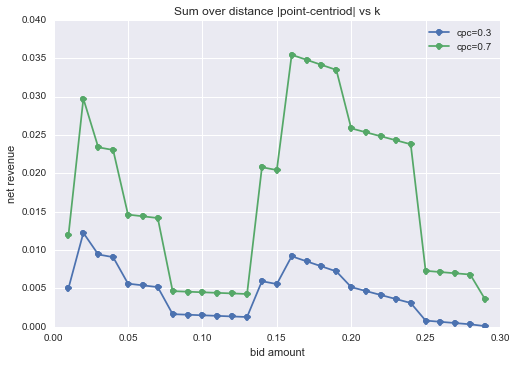

In [121]:
bid_vs_revenue_03 = plt.errorbar(bid, net_revenue_1, fmt='-o')
bid_vs_revenue_07 = plt.errorbar(bid, net_revenue_2, fmt='-o')

xlabel('bid amount')
ylabel('net revenue')
plt.legend([bid_vs_revenue_03, bid_vs_revenue_07],['cpc=0.3', 'cpc=0.7'],loc='upper right')
title('Sum over distance |point-centriod| vs k')
grid(True)

show()

We can see that the optimal net revenue is not necessary to appear at low bid amount: At **adv_cpc** =0.3, optimal bid is at 0.02, but at **adv_cpc** =0.7, optimal bid is at 0.16. Thus, to find the optimal bid amount to maximize the net revenue, we need to walk through the bid amounts. The function shown below is used to find the optimal bid amount to maximize the net revenuse at given features (the bid amount is searched in increment of 0.01):

In [157]:
def get_optimal_bid(model, traffic, device, country):
    adv_cpc = [0.01, 0.02, 0.10, 0.15, 0.30, 0.70]
    bestbid = []
    revenue = []
    for cpc in adv_cpc:
        optimal_bid = -1
        max_revenue = -1
        for i in range(1,100):
            bid = 0.01*i
            net_revenue = compute_revenue(model, cpc, traffic, device, country, bid)
            if net_revenue > max_revenue: optimal_bid, max_revenue = bid, net_revenue
            #print (bid, net_revenue)
        bestbid.append(optimal_bid)
        revenue.append(max_revenue)
        
    df_importance = pd.DataFrame({'adv_cpc': adv_cpc, 'best_bid': bestbid, 'max_revenue' : revenue})
    print (df_importance.head(10))

In [158]:
#get_optimal_bid(best_rf_model, 216145324,22,6)
get_optimal_bid(best_rf_model, 274040327, 26, 9)
#get_optimal_bid(best_rf_model, 93920677, 22, 156)

   adv_cpc  best_bid  max_revenue
0     0.01      0.01     0.000000
1     0.02      0.01     0.000173
2     0.10      0.02     0.003499
3     0.15      0.02     0.005685
4     0.30      0.02     0.012245
5     0.70      0.16     0.035453


Therefore, for **avd_cpc** =0.01, 0.02, 0.1, 0.15, 0.3 and 0.7 and **traffic_source**=274040327, **device** = 26, **country** =9,, the optimal bid amounts to maximize the net revenue are 0.01, 0.01, 0.02, 0.02, 0.02 and 0.16, based on my random-forest-regression model. With different **traffic_source**, **device**, **country** we will have another optimal bid amounts.

## Summary

In this report, I implemented several regression models: decision-tree, random-forest, gradient-boosting-tree, and linear regression models: ridge regression, lasso and Bayesian regression. The benchmarks show random-forest-regression has the best performance, giving lowest RMSE and highest R square. In the second part, I constructed a fucntion using the random-forest-regression model to evaluate the optimal value of bid amount which maximizes the net revenuse.

### Thank you!